<a href="https://colab.research.google.com/github/adamcwatts/ECE-524-Neural_Networks/blob/master/Detectron2_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 20.8MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 4.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=c399275c5218177223712526c2ece8b0eb2869f7409ac64933cf3f4ebebda26b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_w13p6hh
  Running command git 

In [0]:

# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
import os
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from matplotlib import image

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Test Detectron2 with a test image of 2 cyclists


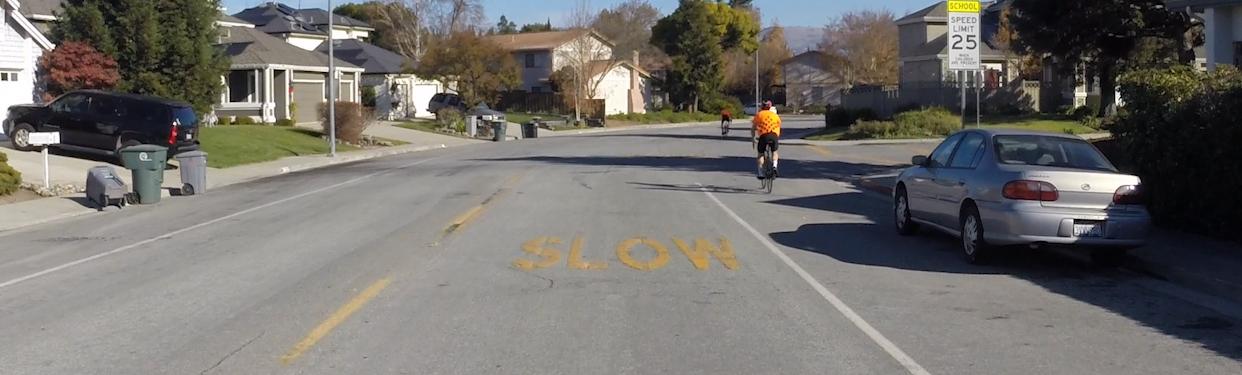

In [0]:
# os.listdir('./drive/My Drive/bike_image_test.png')
im_bike = cv2.imread('./drive/My Drive/Project F/bike_image_test.png')
cv2_imshow(im_bike)

In [0]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im_bike)

model_final_f10217.pkl: 178MB [00:02, 66.9MB/s]                           


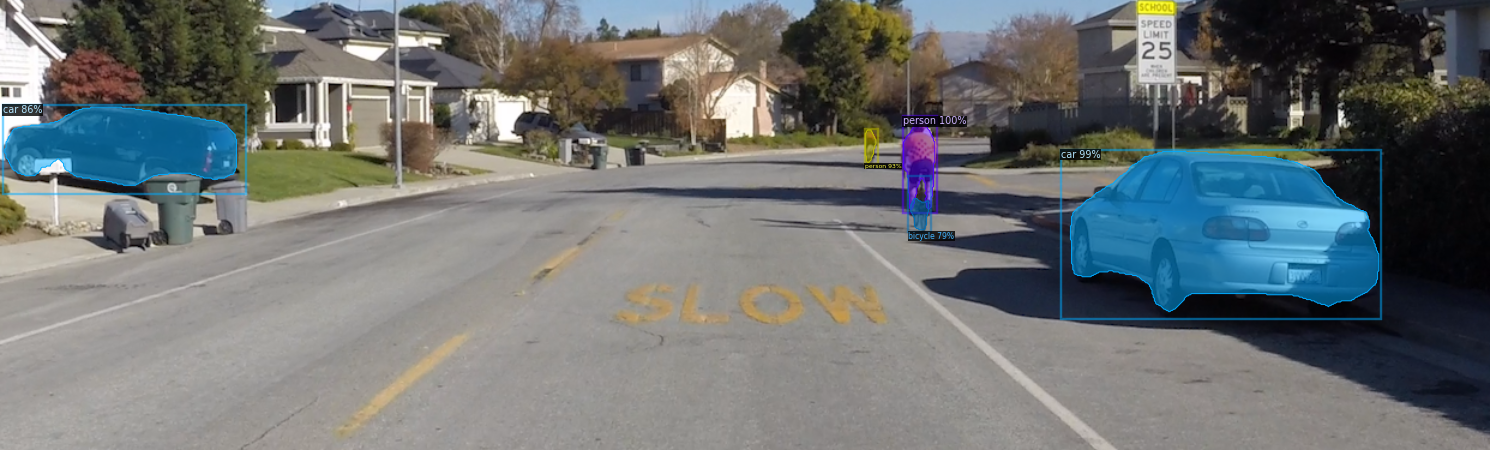

In [0]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im_bike[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

## Intialize file paths and label metadata for images

TRAIN FOLDERS

In [0]:
# Establish the path to the TRAIN data
####################################################################

TRAIN_FOLDERS = [f.path for f in os.scandir(r'/content/drive/My Drive/Project F/TRAIN/') if f.is_dir()]
LABLE_ENDINGS_TRAIN = [x[-1] for x  in TRAIN_FOLDERS]

root_path_string_train = '/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_000'
middle_path_string_train = '/autumn_trainval_labels_1242x375_000'
TRAIN_LABELS = [root_path_string_train + label + middle_path_string_train + label + '.zip' for label in LABLE_ENDINGS_TRAIN]

print('TRAINING IMAGE FOLDERS:', *TRAIN_FOLDERS, sep = '\n')
print('TRAINING LABEL FOLDERS:', *TRAIN_LABELS, sep = '\n')
####################################################################

TRAINING IMAGE FOLDERS:
/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0001
/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0005
/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0003
/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0002
TRAINING LABEL FOLDERS:
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_0001/autumn_trainval_labels_1242x375_0001.zip
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_0005/autumn_trainval_labels_1242x375_0005.zip
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_0003/autumn_trainval_labels_1242x375_0003.zip
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_0002/autumn_trainval_labels_12

TESTING FOLDERS

In [0]:
# Establish the path to the TEST data
####################################################################

TEST_FOLDERS = [f.path for f in os.scandir(r'/content/drive/My Drive/Project F/TEST/') if (f.is_dir() and '0005' not in f.path)]  # 0005 has mismatched labels, therefore dont use
LABLE_ENDINGS_TEST= [x[-1] for x  in TEST_FOLDERS]

root_path_string_test = '/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Winter_1242x375/Winter_1242x375_000'
middle_path_string_test = '/winter_trainval_labels_1242x375_000'
TEST_LABELS = [root_path_string_test + label + middle_path_string_test + label + '.zip' for label in LABLE_ENDINGS_TEST]

print('TESTING IMAGE FOLDERS:', *TEST_FOLDERS, sep = '\n')
print('TESTING lABEL FOLDERS:', *TEST_LABELS, sep = '\n')

####################################################################

TESTING IMAGE FOLDERS:
/content/drive/My Drive/Project F/TEST/winter_trainval_images_1242x375_0004
/content/drive/My Drive/Project F/TEST/winter_trainval_images_1242x375_0002
/content/drive/My Drive/Project F/TEST/winter_trainval_images_1242x375_0001
/content/drive/My Drive/Project F/TEST/winter_trainval_images_1242x375_0003
TESTING lABEL FOLDERS:
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Winter_1242x375/Winter_1242x375_0004/winter_trainval_labels_1242x375_0004.zip
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Winter_1242x375/Winter_1242x375_0002/winter_trainval_labels_1242x375_0002.zip
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Winter_1242x375/Winter_1242x375_0001/winter_trainval_labels_1242x375_0001.zip
/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Winter_1242x375/Winter_1242x375_0003/winter_trainval_labels_1242x375

In [0]:

zip_train_image_labels = []
zip_test_image_labels =[]

for (image_path, label_path) in zip(TRAIN_FOLDERS, TRAIN_LABELS):
  zip_train_image_labels.append(ZipFile(label_path)) # list of zips labels

for (image_path, label_path) in zip(TEST_FOLDERS, TEST_LABELS):
  zip_test_image_labels.append(ZipFile(label_path))



def generate_detectron_dicts(image_path, zip_im_labels):
  # print(type(image_path))
  # print(type(zip_im_labels),'\n')

  print("FOUND IMAGE PATH:" ,image_path)
  print("ZIP LABEL PATH: ", zip_im_labels,'\n')
  # zip_index = TRAIN_FOLDERS.index(image_path)

  # zip_im_labels = zip_train_image_labels[zip_index]
  # zip_path
  # zip_im_labels = ZipFile(zip_im_labels)
  list_of_labels = zip_im_labels.namelist()[::-1][:-1]   # revserse order. Small to large, remove last label which isnt a .txt
  dataset_dicts = []
  for i in range(len(list_of_labels)):
    string_label_data = str(zip_im_labels.read(list_of_labels[i]), 'utf-8')  # convert bytes to string
    partioned_data = string_label_data.split('\n')[0:-1] # split on line break. Dont include last empty break
    
    record = {}  # one record for each image, holds metadata and objs[obj]
    objs = []  # objs holds all dictionaries of obj with box and polygon info

    for line in partioned_data:  # reads each line labeled data text
      if 'Cyclist' in line:      # only get Cyclist Data

          X_min = int(line.split(" ")[4])  # convert 4th column into a int
          Y_min = int(line.split(" ")[5])  # convert 5th column into a int
          X_max = int(line.split(" ")[6])
          Y_max = int(line.split(" ")[7])

          obj = {
          "bbox": [X_min, Y_min, X_max, Y_max],
          "bbox_mode": BoxMode.XYXY_ABS,
          # "segmentation": [[0, 0]],
          "segmentation": [[0, 0, 0, 0 ,0 ,0 ,0 ,0]],  # No Polygon Data
          "category_id": 0,
          "iscrowd": 0
          }
          objs.append(obj)

    file_with_cyclist = list_of_labels[i].split("/")[1].split('.txt')[0]+ '.png'  # returns ->  '01234.png'
    cyclist_path = os.path.join(image_path, file_with_cyclist)
    complete_cyclist_file_path = os.path.join('/content/drive/My Drive/Project F/',cyclist_path)

    record["annotations"] = objs
    record["file_name"] = complete_cyclist_file_path
    record["image_id"] = 1
    record["height"] = 375  # HARD CODED
    record["width"] = 1242  # HARD CODED

    if len(objs) > 0:  # only add to dataset if a cyclist is found in the labels
      dataset_dicts.append(record)

  return dataset_dicts


In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()  # clears all catalogs
master_train_catalog = []
master_test_catalog = []

print("**** COMPILING TRAIN CATALOGS ****\n")
# GENERATE CATALOG FOR ALL TRAIN DATA
for i in range(len(TRAIN_FOLDERS)):
  index = LABLE_ENDINGS_TRAIN[i]

  master_train_catalog.append(generate_detectron_dicts(TRAIN_FOLDERS[i], zip_train_image_labels[i]))
  DatasetCatalog.register("cyclist_train_" + index, lambda i=i: generate_detectron_dicts(TRAIN_FOLDERS[i], zip_train_image_labels[i]))  # needs a silly lambda function to retrieve apparently: Must be a callable function with no arguments....facebook... why?????
  MetadataCatalog.get("cyclist_train_" + index).set(thing_classes=["cyclist"])

print("**** COMPILING TEST CATALOGS ****\n")
# GENERATE CATALOG FOR ALL TEST DATA
for i in range(len(TEST_FOLDERS)):
  index = LABLE_ENDINGS_TEST[i]
  master_test_catalog.append(generate_detectron_dicts(TEST_FOLDERS[i], zip_test_image_labels[i]))
  DatasetCatalog.register("cyclist_test_" + index, lambda i=i: generate_detectron_dicts(TEST_FOLDERS[i], zip_test_image_labels[i]))  # needs a silly lambda function to retrieve apparently: Must be a callable function with no arguments....facebook... why?????
  MetadataCatalog.get("cyclist_test_" + index).set(thing_classes=["cyclist"])


cyclist_metadata = MetadataCatalog.get("cyclist_train_1")  # metadata is the same for all catalogs since each catalog only has cyclists!!

**** COMPILING TRAIN CATALOGS ****

FOUND IMAGE PATH: /content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0001
ZIP LABEL PATH:  <zipfile.ZipFile filename='/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_0001/autumn_trainval_labels_1242x375_0001.zip' mode='r'> 

FOUND IMAGE PATH: /content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0005
ZIP LABEL PATH:  <zipfile.ZipFile filename='/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_0005/autumn_trainval_labels_1242x375_0005.zip' mode='r'> 

FOUND IMAGE PATH: /content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0003
ZIP LABEL PATH:  <zipfile.ZipFile filename='/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Autumn_1242x375/Autumn_1242x375_0003/autumn_trainval_labels_1242x375_0003.zip' mode='r'> 

FOUND IMAGE P

## Verify the Boxes are imported correctly: visuale on the training set

In [0]:
List_of_Catalogs = DatasetCatalog.list()
TRAINING_CATALOGS = [catalog for catalog in List_of_Catalogs if 'train' in catalog]
TESTING_CATALOGS = [catalog for catalog in List_of_Catalogs if 'test' in catalog]

TRAINING_CATALOGS = tuple(TRAINING_CATALOGS + TESTING_CATALOGS[0:-1])  # Tuple of all Training Catalogs
# TESTING_CATALOGS = tuple(TESTING_CATALOGS[-1])  # Tuple of all Testing Catalogs
TESTING_CATALOGS = [TESTING_CATALOGS[-1]]
# TRAINING_CATALOGS

# TRAINING_CATALOGS = tuple(TRAINING_CATALOGS)  # Tuple of all Training Catalogs
# TESTING_CATALOGS = tuple(TESTING_CATALOGS)  # Tuple of all Testing Catalogs
# TRAINING_CATALOGS

print('Number of Training Catalogs Registered:' ,len(TRAINING_CATALOGS))
print('Number of Testing Catalogs Registered:' ,len(TESTING_CATALOGS))

total_ims = 0
for catalog in (master_test_catalog + master_train_catalog):
  total_ims += len(catalog)
print('TOTAL CYCLIST IMAGES:', total_ims)

print(len(master_test_catalog[-1]))  # 1,425 images in last dataset
TESTING_CATALOGS

Number of Training Catalogs Registered: 7
Number of Testing Catalogs Registered: 1
TOTAL CYCLIST IMAGES: 6784
1425


['cyclist_test_3']

{'annotations': [{'bbox': [677, 84, 708, 178], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[0, 0, 0, 0, 0, 0, 0, 0]], 'category_id': 0, 'iscrowd': 0}], 'file_name': '/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0003/000005832.png', 'image_id': 1, 'height': 375, 'width': 1242}


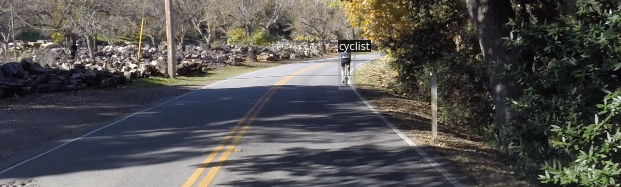

{'annotations': [{'bbox': [562, 105, 577, 153], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[0, 0, 0, 0, 0, 0, 0, 0]], 'category_id': 0, 'iscrowd': 0}], 'file_name': '/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0003/000005799.png', 'image_id': 1, 'height': 375, 'width': 1242}


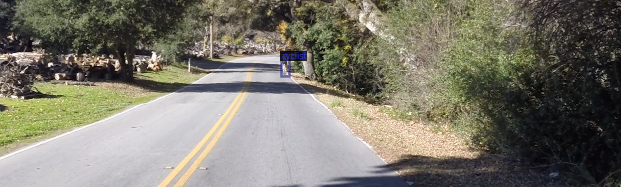

{'annotations': [{'bbox': [700, 96, 735, 199], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[0, 0, 0, 0, 0, 0, 0, 0]], 'category_id': 0, 'iscrowd': 0}], 'file_name': '/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0003/000005837.png', 'image_id': 1, 'height': 375, 'width': 1242}


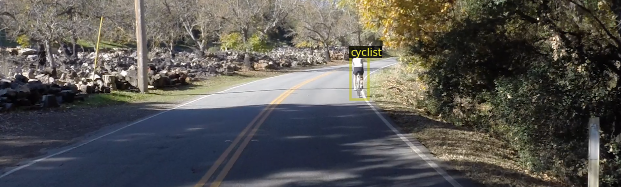

{'annotations': [{'bbox': [313, 118, 325, 154], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[0, 0, 0, 0, 0, 0, 0, 0]], 'category_id': 0, 'iscrowd': 0}], 'file_name': '/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0003/000005769.png', 'image_id': 1, 'height': 375, 'width': 1242}


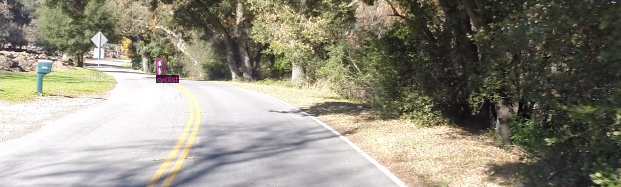

{'annotations': [{'bbox': [523, 123, 538, 171], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[0, 0, 0, 0, 0, 0, 0, 0]], 'category_id': 0, 'iscrowd': 0}], 'file_name': '/content/drive/My Drive/Project F/TRAIN/autumn_trainval_images_1242x375_0003/000005794.png', 'image_id': 1, 'height': 375, 'width': 1242}


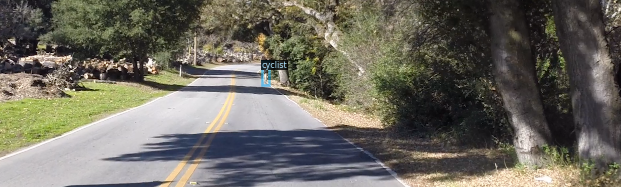

In [0]:
#####  CHOOSE CATALOG NUMBER TO VERIFY BOXES ARE IMPORTED CORRECTLY #####
catalog_number = 2   #
pics_to_show = 5
###############

for d in random.sample(master_train_catalog[catalog_number], pics_to_show):  
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cyclist_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = '/content/drive/My Drive/Project F/Detectron Model/train/Adams_results'

('cyclist_train_1', 'cyclist_train_5', 'cyclist_train_3', 'cyclist_train_2')

In [0]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = TRAINING_CATALOGS
cfg.DATASETS.TEST = ()  # No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method. ???? DEBUG
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

trainer.resume_or_load(resume=False)
trainer.train()

[04/27 04:44:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 79.4MB/s]                           


[04/27 04:44:26 d2.engine.train_loop]: Starting training from iteration 0
[04/27 04:44:42 d2.utils.events]:  eta: 0:12:30  iter: 19  total_loss: 1.603  loss_cls: 0.649  loss_box_reg: 0.229  loss_mask: 0.685  loss_rpn_cls: 0.033  loss_rpn_loc: 0.007  time: 0.8197  data_time: 0.6937  lr: 0.000003  max_mem: 1820M
[04/27 04:44:58 d2.utils.events]:  eta: 0:12:18  iter: 39  total_loss: 1.586  loss_cls: 0.610  loss_box_reg: 0.246  loss_mask: 0.672  loss_rpn_cls: 0.033  loss_rpn_loc: 0.008  time: 0.7869  data_time: 0.6145  lr: 0.000006  max_mem: 1820M
[04/27 04:45:12 d2.utils.events]:  eta: 0:11:52  iter: 59  total_loss: 1.429  loss_cls: 0.532  loss_box_reg: 0.199  loss_mask: 0.651  loss_rpn_cls: 0.030  loss_rpn_loc: 0.011  time: 0.7680  data_time: 0.5911  lr: 0.000009  max_mem: 1835M
[04/27 04:45:27 d2.utils.events]:  eta: 0:11:32  iter: 79  total_loss: 1.320  loss_cls: 0.442  loss_box_reg: 0.200  loss_mask: 0.613  loss_rpn_cls: 0.038  loss_rpn_loc: 0.012  time: 0.7529  data_time: 0.5697  lr:

In [0]:
# Look at training curves in tensorboard:  
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir '/content/drive/My Drive/Project F/Detectron Model/train/Adams_results'   # Physical directory...apparently cfg.OUTPUT_DIR doesn't work.....

In [0]:
print(cfg.OUTPUT_DIR)   # might need to change the output to a different location!!
os.listdir(cfg.OUTPUT_DIR)

/content/drive/My Drive/Project F/Detectron Model/train/Adams_results


['events.out.tfevents.1587962663.9545226996b0.118.0',
 'model_final.pth',
 'last_checkpoint']

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.70   # set the testing threshold for this model
cfg.DATASETS.TEST = TESTING_CATALOGS  # entire tuple as our testing catalog
predictor = DefaultPredictor(cfg)

## Check out how the Model performs on a few random images from the testing set

### predict on test set




In [0]:
master_test_catalog[-1][0]

{'annotations': [{'bbox': [4, 194, 18, 243],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0,
   'segmentation': [[0, 0, 0, 0, 0, 0, 0, 0]]}],
 'file_name': '/content/drive/My Drive/Project F/TEST/winter_trainval_images_1242x375_0003/000001790.png',
 'height': 375,
 'image_id': 1,
 'width': 1242}

In [0]:
from detectron2.utils.visualizer import ColorMode
random.seed(a=None)
#####  CHOOSE CATALOG NUMBER TO VERIFY BOXES ARE IMPORTED CORRECTLY #####
testing_catalog_number = -1   #
test_pics_to_show = 5
###############
dataset_dicts = master_train_catalog[testing_catalog_number]

for photo in random.sample(dataset_dicts, test_pics_to_show):   
    print(photo['file_name'])
    print('PREDICTED:')
    im = cv2.imread(photo["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cyclist_metadata, 
                   scale=0.99, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

    print('GROUND TRUTH:')
    img = cv2.imread(photo["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cyclist_metadata, scale=0.99)
    vis = visualizer.draw_dataset_dict(photo)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Inference Methods


In [0]:
#####  CHOOSE CATALOG NUMBER TO VERIFY BOXES ARE IMPORTED CORRECTLY #####
testing_catalog_number = -1   #
test_pics_to_show = 1
###############
dataset_dicts = master_test_catalog[testing_catalog_number]
TOTAL_PICS = len(dataset_dicts)
UNDER_CLASSIFICATION = 0
OVER_CLASSIFICATION = 0
TOTAL_CLASSIFICATIONS = 0
print_counter = [100, 200, 300, 400, 500, 600,
                 700 , 800 , 900, 1000, 1100, 1200, 1300, 1400, 1500]
idx = 0
# for photo in random.sample(dataset_dicts, test_pics_to_show):   
for counter, photo in enumerate(dataset_dicts):   
    im = cv2.imread(photo["file_name"])
    outputs = predictor(im)
    my_instance = outputs['instances']
    # print(my_instance.get_fields().keys())
    instance_list = list(my_instance.get_fields()['scores'].size()) # makes object to dictionary -> grabs value which is tensor object  -> cast to list
    instance_count = instance_list[0]

    actual_count = len(photo['annotations'])
    TOTAL_CLASSIFICATIONS += actual_count
    # print(instance_count, actual_count)

    if instance_count < actual_count:
      UNDER_CLASSIFICATION += (actual_count-instance_count)
    if instance_count > actual_count:
      OVER_CLASSIFICATION += (instance_count - actual_count)

  
    if counter >= print_counter[idx]:
      print(counter,'out of:', TOTAL_PICS)
      idx += 1
    
    # print(((counter + 1)/TOTAL_PICS)*100)
    # print(instance_count)
    # v = Visualizer(im[:, :, ::-1],
    #                metadata=cyclist_metadata, 
    #                scale=0.99, 
    #               #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    #                )
    # v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(v.get_image()[:, :, ::-1])

print('Under Classification Count:',UNDER_CLASSIFICATION, '\nOver Classification Count:',OVER_CLASSIFICATION)

100 out of: 1425
200 out of: 1425
300 out of: 1425
400 out of: 1425
500 out of: 1425
600 out of: 1425
700 out of: 1425
800 out of: 1425
900 out of: 1425
1000 out of: 1425
1100 out of: 1425
1200 out of: 1425
1300 out of: 1425
1400 out of: 1425
Under Classification Count: 91 
Over Classification Count: 14


In [0]:
print('Under Classification %:',UNDER_CLASSIFICATION/TOTAL_CLASSIFICATIONS * 100, '\nOver Classification %:',OVER_CLASSIFICATION/TOTAL_CLASSIFICATIONS * 100)
print('Total Instance Counts:', TOTAL_CLASSIFICATIONS)

Under Classification %: 6.385964912280702 
Over Classification %: 0.9824561403508772
Total Instance Counts: 1425


In [0]:
# #####  CHOOSE CATALOG NUMBER TO VERIFY BOXES ARE IMPORTED CORRECTLY #####
testing_catalog_number = -1   #
# test_pics_to_show = 1
# ###############
dataset_dicts = master_test_catalog[testing_catalog_number]
for photo in random.sample(dataset_dicts, test_pics_to_show):   
# for counter, photo in enumerate(dataset_dicts):   
    im = cv2.imread(photo["file_name"])
    outputs = predictor(im)
    my_instance = outputs['instances']
    # print(my_instance.get_fields().keys())
    instance_list = list(my_instance.get_fields()['scores'].size()) # makes object to dictionary -> grabs value which is tensor object  -> cast to list
    instance_count = instance_list[0]

    v = Visualizer(im[:, :, ::-1],
                   metadata=cyclist_metadata, 
                   scale=0.99, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
                   )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluator
from detectron2.data import build_detection_test_loader
output_val_dir = '/content/drive/My Drive/Project F/Detectron Model/val/Adams_results'
catalog_number = 0

evaluator = COCOEvaluator(TESTING_CATALOGS[catalog_number], cfg, False, output_dir=output_val_dir)
val_loader = build_detection_test_loader(cfg, TESTING_CATALOGS[catalog_number])  # doesnt work on tuples
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [04/27 05:03:39 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'cyclist_test_3'. Trying to convert it to COCO format ...
[04/27 05:03:39 d2.data.datasets.coco]: Converting dataset annotations in 'cyclist_test_3' to COCO format ...)
FOUND IMAGE PATH: /content/drive/My Drive/Project F/TEST/winter_trainval_images_1242x375_0003
ZIP LABEL PATH:  <zipfile.ZipFile filename='/content/drive/My Drive/Project F/Training + Val/Cyclist_dataset_1242x375_KITTI_format/Winter_1242x375/Winter_1242x375_0003/winter_trainval_labels_1242x375_0003.zip' mode='r'> 

[04/27 05:03:39 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/27 05:03:39 d2.data.datasets.coco]: Conversion finished, num images: 1425, num annotations: 1425
[04/27 05:03:39 d2.data.datasets.coco]: Caching annotations in COCO format: /content/drive/My Drive/Project F/Detectron Model/val/Adams_results/cyclist_test_3_coco_format.json
FOUND IMAGE PATH: /content/drive/My Drive/Project F/T

OrderedDict([('bbox',
              {'AP': 5.818696038515179,
               'AP50': 7.920792079207921,
               'AP75': 6.91006600660066,
               'APl': nan,
               'APm': nan,
               'APs': 6.148774255326709}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APl': nan,
               'APm': nan,
               'APs': 0.0})])

In [0]:
# No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
# trainer.test(cfg, trainer.model, None)